In [1]:
## Imports
import torch
import pennylane as qml
import matplotlib.pyplot as plt
from itertools import product
import datetime
import numpy as np
import os
import sys
import pandas as pd

torch.manual_seed(42)
torch.set_num_threads(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
## Constants
# QNet Parameter
N_WIRES = 4
N_LAYERS = 5

# FNN Basis Net
HIDDEN_LAYERS_FNN = 2
NEURONS_FNN = 10

# Domain Parameter
X_COLOC_POINTS = 50
Y_COLOC_POINTS = 25
BOUNDARY_SCALE = 10e1

In [3]:
##  Generate Domain

# Generate Collocation Points
x = torch.linspace(0.0, 2.0, X_COLOC_POINTS)
y = torch.linspace(0.0, 1.0, Y_COLOC_POINTS)
input_domain = torch.tensor(list(product(x, y)))

dir_boundary_mask = (input_domain[:, 0] == 0.0) | (input_domain[:, 0] == 2.0)
dir_boundary_colloc = input_domain[dir_boundary_mask]

# Neumann Boundary
neu_boundary_mask = (input_domain[:, 1] == 0.0) | (input_domain[:, 1] == 1.0)
neu_boundary_colloc = input_domain[neu_boundary_mask & ~dir_boundary_mask] 

# Combined Boundary Mask
boundary_mask = dir_boundary_mask | neu_boundary_mask

# Filter out boundary points from domain_colloc
interior_colloc = input_domain[~boundary_mask]

input_domain = input_domain.clone().detach().requires_grad_(True).to(device)
dir_boundary_colloc = dir_boundary_colloc.clone().detach().requires_grad_(True).to(device)
neu_boundary_colloc = neu_boundary_colloc.clone().detach().requires_grad_(True).to(device)
interior_colloc = interior_colloc.clone().detach().requires_grad_(True).to(device)

domain_bounds = torch.tensor([[0.0, 0.0], [2.0, 1.0]], device=device)

# # Plot domain
# plt.scatter(dir_boundary_colloc[:,0].detach().cpu(),dir_boundary_colloc[:,1].detach().cpu(), c="r", label="Dirichlet", s=10)
# plt.scatter(neu_boundary_colloc[:,0].detach().cpu(),neu_boundary_colloc[:,1].detach().cpu(), c="blue", label="Neumann", s=10)
# plt.scatter(interior_colloc[:,0].detach().cpu(),interior_colloc[:,1].detach().cpu(), c="black", label="Interior", s=10)
# plt.grid()
# plt.legend()
# plt.show()


In [4]:
## Create the Model

# Define QPINN
@qml.qnode(qml.device("default.qubit", wires=N_WIRES), interface="torch")
def circuit(x, basis):

    # Embedding
    for i in range(N_WIRES):
        if i % 2 == 0:
            qml.RY(basis[i] * x[0], wires=i)
        else:
            qml.RY(basis[i] * x[1], wires=i)
    
    # Variational ansatz
    for i in range(N_LAYERS):
        for j in range(N_WIRES):
            qml.RX(theta[i,j,0], wires=j)
            qml.RY(theta[i,j,1], wires=j)
            qml.RZ(theta[i,j,2], wires=j)
    
        for j in range(N_WIRES - 1):
            qml.CNOT(wires=[j, j + 1]) 

    # Cost Function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(N_WIRES)]))

# Define FNN for the basis
class FNN(torch.nn.Module):
    def __init__(self, n_hidden_layers, branch_width, output_dim=N_WIRES):
        super().__init__()

        self.n_hidden_layers = n_hidden_layers
        self.branch_width = branch_width
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, branch_width))
        for i in range(n_hidden_layers -1):
            self.layers.append(torch.nn.Linear(branch_width, branch_width))
        self.layers.append(torch.nn.Linear(branch_width, output_dim))

    def forward(self, x):
        for i in range(self.n_hidden_layers):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[self.n_hidden_layers](x)
        return x

def model(x):
    # Rescale input to [-0.95, 0.95]       
    x_rescaled = 1.9 * (x - domain_bounds[0])/(domain_bounds[1] - domain_bounds[0]) - 0.95
    return circuit(x_rescaled.T, basisNet(x_rescaled).T)

def model_pinn(x):
    x_rescaled = 1.9 * (x - domain_bounds[0])/(domain_bounds[1] - domain_bounds[0]) - 0.95
    return pinn(x_rescaled).squeeze()

def get_n_params(fnn_model):
    pp=0
    for p in list(fnn_model.parameters()):
        print(p.size())
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [5]:

u_interp = np.load(
    os.path.dirname(os.path.abspath("")) + "/Poisson/poisson_reference_solution.npy",
    allow_pickle=True,
).item()

def reference_solution(data):
    output = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        output[i] = u_interp([data[i, 0], data[i, 1]]).squeeze()
    return output

reference_values = torch.tensor(reference_solution(input_domain.detach().cpu()), device=device)


In [6]:
## Define the problem
def source_term(x):
    return 10 * torch.exp(-((x[:, 0] - 0.5) ** 2 + (x[:, 1] - 0.5) ** 2) / 0.02)

def neu_boundary_term(x):
    return torch.sin(5 * x[:, 0])

def dir_loss_fnc(model):
    u_dir = model(dir_boundary_colloc)
    return torch.mean(u_dir**2)

def neu_loss_fnc(model):
    u_neu = model(neu_boundary_colloc)

    du_d = torch.autograd.grad(u_neu, neu_boundary_colloc, grad_outputs=torch.ones_like(u_neu), create_graph=True)[0]
    du_dy = du_d[:, 1]

    # Flip signs for first values, since they have to be outward facing relative to the domain
    du_dy[::2] *= -1.0

    g = neu_boundary_term(neu_boundary_colloc)
    return torch.mean((du_dy - g) ** 2)

def pde_loss_fnc(model):
    u = model(interior_colloc)
    f = source_term(interior_colloc)

    grad_out = torch.ones_like(u)
    du_d = torch.autograd.grad(u, interior_colloc, grad_outputs=grad_out, create_graph=True)[0]
    du_dx = du_d[:, 0]
    du_dy = du_d[:, 1]

    du_dxd = torch.autograd.grad(du_dx, interior_colloc, grad_outputs=grad_out, create_graph=True)[0]
    du_dxdx = du_dxd[:, 0]

    du_dyd = torch.autograd.grad(du_dy, interior_colloc, grad_outputs=grad_out, create_graph=True)[0]
    du_dydy = du_dyd[:, 1]

    pde_res = -du_dxdx - du_dydy - f
    return torch.mean(pde_res**2)


def loss_fnc():
    dir_loss = dir_loss_fnc(model)
    neu_loss = neu_loss_fnc(model)
    pde_loss = pde_loss_fnc(model)
    return BOUNDARY_SCALE * (dir_loss + neu_loss) + pde_loss

def loss_fnc_PINN():
    dir_loss = dir_loss_fnc(model_pinn)
    neu_loss = neu_loss_fnc(model_pinn)
    pde_loss = pde_loss_fnc(model_pinn)
    return BOUNDARY_SCALE * (dir_loss + neu_loss) + pde_loss

def compute_MSE_ref(model):
    prediction = model(input_domain)
    return torch.mean((prediction-reference_values)**2).detach().cpu().item()

def compute_lmax_norm(model):
    prediction = model(input_domain)
    return torch.max(torch.abs(prediction-reference_values)).detach().cpu().item()


In [7]:
## Train the model
qpinn_data = []
pinn_data = []

for i in range(3):
    # Create initial parameters and BasisNet object
    theta = torch.rand(N_LAYERS, N_WIRES, 3, device=device, requires_grad=True)
    basisNet = FNN(2, 10).to(device)
    pinn = FNN(2, 13, output_dim=1).to(device)

    # Number of trainable parameters
    print("Number of trainable parameters in QPINN: ", get_n_params(basisNet) + theta.flatten().shape[0])
    print("Number of trainable parameters in PINN: ", get_n_params(pinn))

    opt = torch.optim.LBFGS([theta, *basisNet.parameters()], line_search_fn="strong_wolfe")
    opt_PINN = torch.optim.LBFGS(pinn.parameters(), line_search_fn="strong_wolfe")

    loss_history_qpinn = []
    loss_history_pinn = []

    def closure():
        opt.zero_grad()
        l = loss_fnc()
        l.backward()
        return l

    def closure_PINN():
        opt_PINN.zero_grad()
        l = loss_fnc_PINN()
        l.backward()
        return l
    
    for i in range(100):
        opt.step(closure)
        loss_history_qpinn.append(loss_fnc().item())
        print(f"QPINN: Epoch {i}, Loss: {loss_fnc().item()}")


    for i in range(100):
        opt_PINN.step(closure_PINN)
        loss_history_pinn.append(loss_fnc_PINN().item())
        print(f"PINN: Epoch {i}, Loss: {loss_fnc_PINN().item()}")


    qpinn_data.append(loss_history_qpinn)
    pinn_data.append(loss_history_pinn)

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([4, 10])
torch.Size([4])
Number of trainable parameters in QPINN:  244
torch.Size([13, 2])
torch.Size([13])
torch.Size([13, 13])
torch.Size([13])
torch.Size([1, 13])
torch.Size([1])
Number of trainable parameters in PINN:  235
QPINN: Epoch 0, Loss: 22.746049570070802
QPINN: Epoch 1, Loss: 6.1814375511056925
QPINN: Epoch 2, Loss: 3.129111881173232
QPINN: Epoch 3, Loss: 1.7519045668915147
QPINN: Epoch 4, Loss: 0.9565354459732536
QPINN: Epoch 5, Loss: 0.7350767268539999
QPINN: Epoch 6, Loss: 0.5812255638752819
QPINN: Epoch 7, Loss: 0.4891583628812568
QPINN: Epoch 8, Loss: 0.44297514144426264
QPINN: Epoch 9, Loss: 0.40886223857684856
QPINN: Epoch 10, Loss: 0.3745507279871241
QPINN: Epoch 11, Loss: 0.32692797142704144
QPINN: Epoch 12, Loss: 0.29973630109214433
QPINN: Epoch 13, Loss: 0.24992177268934412
QPINN: Epoch 14, Loss: 0.2261219234067191
QPINN: Epoch 15, Loss: 0.2014687647302651
QPINN: Epoch 16, Loss

/var/folders/mg/wnh4_z1j7_l6stml2x35_z340000gn/T/ipykernel_50779/4097730938.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


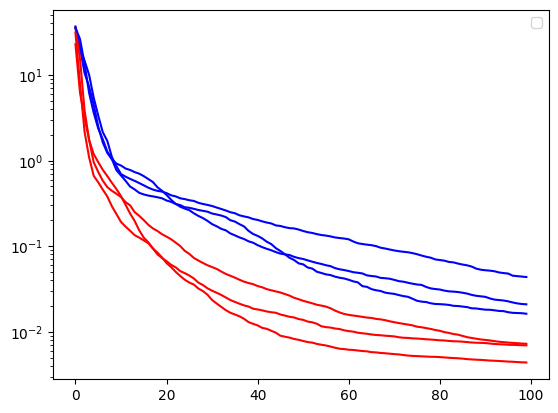

In [8]:
for i in range(3):
    plt.plot(qpinn_data[i], color="red")
    plt.plot(pinn_data[i], color="blue")
plt.legend()
plt.yscale("log")
plt.savefig("poisson_qpinn_vs_pinn.png", dpi=200)
plt.show()

In [9]:
print("idx loss_qpinn_1 loss_qpinn_2 loss_qpinn_3 loss_qpinn_mean")
for i in range(100):
    print(i, qpinn_data[0][i], qpinn_data[1][i], qpinn_data[2][i], np.mean([qpinn_data[0][i], qpinn_data[1][i], qpinn_data[2][i]]))

idx loss_qpinn_1 loss_qpinn_2 loss_qpinn_3 loss_qpinn_mean
0 22.746049570070802 31.101298000880785 35.35573049799627 29.734359356315952
1 6.1814375511056925 7.874620443863325 15.340945492175607 9.799001162381542
2 3.129111881173232 2.1622409937143807 3.851053032854246 3.047468635913953
3 1.7519045668915147 1.0887294627387725 1.7350494310900384 1.5252278202401086
4 0.9565354459732536 0.6647288120140011 1.1902995767347502 0.9371879449073349
5 0.7350767268539999 0.5568226561744378 0.9576569473370817 0.7498521101218398
6 0.5812255638752819 0.45761861379792457 0.7784651607575004 0.6057697794769022
7 0.4891583628812568 0.3797879054560629 0.6569345043679267 0.5086269242350822
8 0.44297514144426264 0.2920480550288169 0.5496093628261391 0.42821085309973955
9 0.40886223857684856 0.2371676395132578 0.4640051700871819 0.37001168272576274
10 0.3745507279871241 0.19168911104253894 0.38426033404269333 0.3168333910241188
11 0.32692797142704144 0.1693696728953542 0.30427229574278236 0.26685664668839265

In [10]:
print("idx loss_pinn_1 loss_pinn_2 loss_pinn_3 loss_pinn_mean")
for i in range(100):
    print(i, pinn_data[0][i], pinn_data[1][i], pinn_data[2][i], np.mean([pinn_data[0][i], pinn_data[1][i], pinn_data[2][i]]))

idx loss_pinn_1 loss_pinn_2 loss_pinn_3 loss_pinn_mean
0 36.665313720703125 35.39430618286133 35.493141174316406 35.85092035929362
1 20.294795989990234 20.518604278564453 26.092798233032227 22.302066167195637
2 14.616191864013672 10.500579833984375 13.505998611450195 12.87425676981608
3 9.988492012023926 7.2752556800842285 6.149143218994141 7.804296970367432
4 5.420831203460693 4.47120475769043 3.628229856491089 4.506755272547404
5 3.3462460041046143 2.495441198348999 2.367428779602051 2.7363719940185547
6 2.141695976257324 1.6255563497543335 1.7681841850280762 1.8451455036799114
7 1.6893603801727295 1.2243633270263672 1.271634578704834 1.3951194286346436
8 1.0980753898620605 1.037933588027954 1.035404920578003 1.0571379661560059
9 0.859138011932373 0.9198834896087646 0.7710034847259521 0.8500083287556967
10 0.6954002380371094 0.8735547065734863 0.6689817905426025 0.7459789117177328
11 0.6476544737815857 0.8062757253646851 0.5799664258956909 0.6779655416806539
12 0.6106320023536682 0.7